In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Download NLTK resources
nltk.download('stopwords')

# Load the dataset
file_path = "olid-training-v1.0.xlsx"
df = pd.read_excel(file_path)

# Mapping OLID labels to toxicity categories
def map_toxicity(row):
    categories = {
        'toxic': 0, 'severe_toxic': 0, 'obscene': 0,
        'threat': 0, 'insult': 0, 'identity_hate': 0
    }

    if row['subtask_a'] == 'OFF':
        categories['toxic'] = 1  # General toxicity
        if row['subtask_b'] == 'TIN':
            categories['insult'] = 1  # Insults
            if row['subtask_c'] == 'IND' or row['subtask_c'] == 'GRP':
                categories['identity_hate'] = 1  # Identity-based hate
            if row['subtask_c'] == 'OTH':
                categories['threat'] = 1  # Other threats
        elif row['subtask_b'] == 'UNT':
            categories['obscene'] = 1  # Untargeted offensive speech
    return pd.Series(categories)

# Apply the mapping
df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = df.apply(map_toxicity, axis=1)

# Text cleaning function
def clean_text(text):
    # Convert to string to handle potential non-string values
    text = str(text)
    text = text.lower()
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(f"[{string.punctuation}]", '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))
    return text

# Apply text cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_tweet'])
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate models for each toxicity category
for category in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f"Training models for {category}...")
    # Select target variable for the current category
    y_train_category = y_train[category]
    y_test_category = y_test[category]

    # Check if y_train_category contains more than one class
    if len(y_train_category.unique()) > 1:
        for name, model in models.items():
            print(f"Training {name}...")
            # Fit the model using the target variable for the current category
            model.fit(X_train, y_train_category)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test_category, y_pred)
            print(f"Performance of {name} for {category}:")
            print(classification_report(y_test_category, y_pred))
            print(f"Accuracy: {accuracy:.4f}")
            print("-" * 50)
    else:
        print(f"Skipping {category} due to insufficient class representation in training data.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training models for toxic...
Training Logistic Regression...
Performance of Logistic Regression for toxic:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1733
           1       0.81      0.37      0.50       915

    accuracy                           0.75      2648
   macro avg       0.78      0.66      0.67      2648
weighted avg       0.77      0.75      0.72      2648

Accuracy: 0.7519
--------------------------------------------------
Training Support Vector Machine...
Performance of Support Vector Machine for toxic:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1733
           1       0.78      0.43      0.56       915

    accuracy                           0.76      2648
   macro avg       0.77      0.68      0.70      2648
weighted avg       0.76      0.76      0.74      2648

Accuracy: 0.7613
--------------------------------------------------
Training Random For

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:34:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for toxic:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      1733
           1       0.77      0.40      0.52       915

    accuracy                           0.75      2648
   macro avg       0.76      0.67      0.68      2648
weighted avg       0.75      0.75      0.72      2648

Accuracy: 0.7500
--------------------------------------------------
Training models for severe_toxic...
Skipping severe_toxic due to insufficient class representation in training data.
Training models for obscene...
Training Logistic Regression...
Performance of Logistic Regression for obscene:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2525
           1       0.57      0.03      0.06       123

    accuracy                           0.95      2648
   macro avg       0.76      0.52      0.52      2648
weighted avg       0.94      0.95      0.93      2648

Accuracy: 0.9539

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performance of Random Forest for obscene:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2525
           1       0.67      0.02      0.03       123

    accuracy                           0.95      2648
   macro avg       0.81      0.51      0.50      2648
weighted avg       0.94      0.95      0.93      2648

Accuracy: 0.9539
--------------------------------------------------
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:35:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for obscene:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2525
           1       0.27      0.03      0.06       123

    accuracy                           0.95      2648
   macro avg       0.61      0.51      0.52      2648
weighted avg       0.92      0.95      0.93      2648

Accuracy: 0.9509
--------------------------------------------------
Training models for threat...
Training Logistic Regression...
Performance of Logistic Regression for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.00      0.00      0.00        85

    accuracy                           0.97      2648
   macro avg       0.48      0.50      0.49      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9679
--------------------------------------------------
Training Support Vector Machine...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performance of Support Vector Machine for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.00      0.00      0.00        85

    accuracy                           0.97      2648
   macro avg       0.48      0.50      0.49      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9679
--------------------------------------------------
Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performance of Random Forest for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.00      0.00      0.00        85

    accuracy                           0.97      2648
   macro avg       0.48      0.50      0.49      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9679
--------------------------------------------------
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c

Performance of XGBoost for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.20      0.01      0.02        85

    accuracy                           0.97      2648
   macro avg       0.58      0.51      0.50      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9668
--------------------------------------------------
Training models for insult...
Training Logistic Regression...
Performance of Logistic Regression for insult:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84      1856
           1       0.72      0.28      0.40       792

    accuracy                           0.75      2648
   macro avg       0.74      0.62      0.62      2648
weighted avg       0.75      0.75      0.71      2648

Accuracy: 0.7519
--------------------------------------------------
Training Support Vector Machine...
Performance of Support Vector M

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for insult:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1856
           1       0.66      0.31      0.42       792

    accuracy                           0.75      2648
   macro avg       0.71      0.62      0.63      2648
weighted avg       0.73      0.75      0.71      2648

Accuracy: 0.7462
--------------------------------------------------
Training models for identity_hate...
Training Logistic Regression...
Performance of Logistic Regression for identity_hate:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1941
           1       0.69      0.22      0.34       707

    accuracy                           0.77      2648
   macro avg       0.73      0.59      0.60      2648
weighted avg       0.75      0.77      0.72      2648

Accuracy: 0.7659
--------------------------------------------------
Training Support Vector Machine...
Performance of Su

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:38:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for identity_hate:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1941
           1       0.64      0.26      0.37       707

    accuracy                           0.76      2648
   macro avg       0.71      0.60      0.61      2648
weighted avg       0.74      0.76      0.73      2648

Accuracy: 0.7632
--------------------------------------------------


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training models for toxic...
Training Logistic Regression...
Performance of Logistic Regression for toxic:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1733
           1       0.81      0.37      0.50       915

    accuracy                           0.75      2648
   macro avg       0.78      0.66      0.67      2648
weighted avg       0.77      0.75      0.72      2648

Accuracy: 0.7519
--------------------------------------------------
Training Support Vector Machine...
Performance of Support Vector Machine for toxic:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1733
           1       0.78      0.43      0.56       915

    accuracy                           0.76      2648
   macro avg       0.77      0.68      0.70      2648
weighted avg       0.76      0.76      0.74      2648

Accuracy: 0.7613
--------------------------------------------------
Training Random For

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for toxic:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      1733
           1       0.77      0.40      0.52       915

    accuracy                           0.75      2648
   macro avg       0.76      0.67      0.68      2648
weighted avg       0.75      0.75      0.72      2648

Accuracy: 0.7500
--------------------------------------------------
Training models for severe_toxic...
Skipping severe_toxic due to insufficient class representation in training data.
Training models for obscene...
Training Logistic Regression...
Performance of Logistic Regression for obscene:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2525
           1       0.57      0.03      0.06       123

    accuracy                           0.95      2648
   macro avg       0.76      0.52      0.52      2648
weighted avg       0.94      0.95      0.93      2648

Accuracy: 0.9539

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Performance of Support Vector Machine for obscene:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2525
           1       0.00      0.00      0.00       123

    accuracy                           0.95      2648
   macro avg       0.48      0.50      0.49      2648
weighted avg       0.91      0.95      0.93      2648

Accuracy: 0.9535
--------------------------------------------------
Training Random Forest...
Performance of Random Forest for obscene:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2525
           1       0.67      0.02      0.03       123

    accuracy                           0.95      2648
   macro avg       0.81      0.51      0.50      2648
weighted avg       0.94      0.95      0.93      2648

Accuracy: 0.9539
--------------------------------------------------
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for obscene:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2525
           1       0.27      0.03      0.06       123

    accuracy                           0.95      2648
   macro avg       0.61      0.51      0.52      2648
weighted avg       0.92      0.95      0.93      2648

Accuracy: 0.9509
--------------------------------------------------
Training models for threat...
Training Logistic Regression...
Performance of Logistic Regression for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.00      0.00      0.00        85

    accuracy                           0.97      2648
   macro avg       0.48      0.50      0.49      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9679
--------------------------------------------------
Training Support Vector Machine...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Performance of Support Vector Machine for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.00      0.00      0.00        85

    accuracy                           0.97      2648
   macro avg       0.48      0.50      0.49      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9679
--------------------------------------------------
Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Performance of Random Forest for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.00      0.00      0.00        85

    accuracy                           0.97      2648
   macro avg       0.48      0.50      0.49      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9679
--------------------------------------------------
Training XGBoost...
Performance of XGBoost for threat:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2563
           1       0.20      0.01      0.02        85

    accuracy                           0.97      2648
   macro avg       0.58      0.51      0.50      2648
weighted avg       0.94      0.97      0.95      2648

Accuracy: 0.9668
--------------------------------------------------
Training models for insult...
Training Logistic Regression...
Performance of Logistic Regression for insult:
     

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for insult:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1856
           1       0.66      0.31      0.42       792

    accuracy                           0.75      2648
   macro avg       0.71      0.62      0.63      2648
weighted avg       0.73      0.75      0.71      2648

Accuracy: 0.7462
--------------------------------------------------
Training models for identity_hate...
Training Logistic Regression...
Performance of Logistic Regression for identity_hate:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1941
           1       0.69      0.22      0.34       707

    accuracy                           0.77      2648
   macro avg       0.73      0.59      0.60      2648
weighted avg       0.75      0.77      0.72      2648

Accuracy: 0.7659
--------------------------------------------------
Training Support Vector Machine...
Performance of Su

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:49:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance of XGBoost for identity_hate:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1941
           1       0.64      0.26      0.37       707

    accuracy                           0.76      2648
   macro avg       0.71      0.60      0.61      2648
weighted avg       0.74      0.76      0.73      2648

Accuracy: 0.7632
--------------------------------------------------
         Category                   Model  Accuracy  F1-Score
0           toxic     Logistic Regression  0.751888  0.720587
1           toxic  Support Vector Machine  0.761329  0.739658
2           toxic           Random Forest  0.758686  0.737975
3           toxic                 XGBoost  0.750000  0.724332
4         obscene     Logistic Regression  0.953927  0.933889
5         obscene  Support Vector Machine  0.953550  0.930877
6         obscene           Random Forest  0.953927  0.932523
7         obscene                 XGBoost  0.950906  0.932210
8    

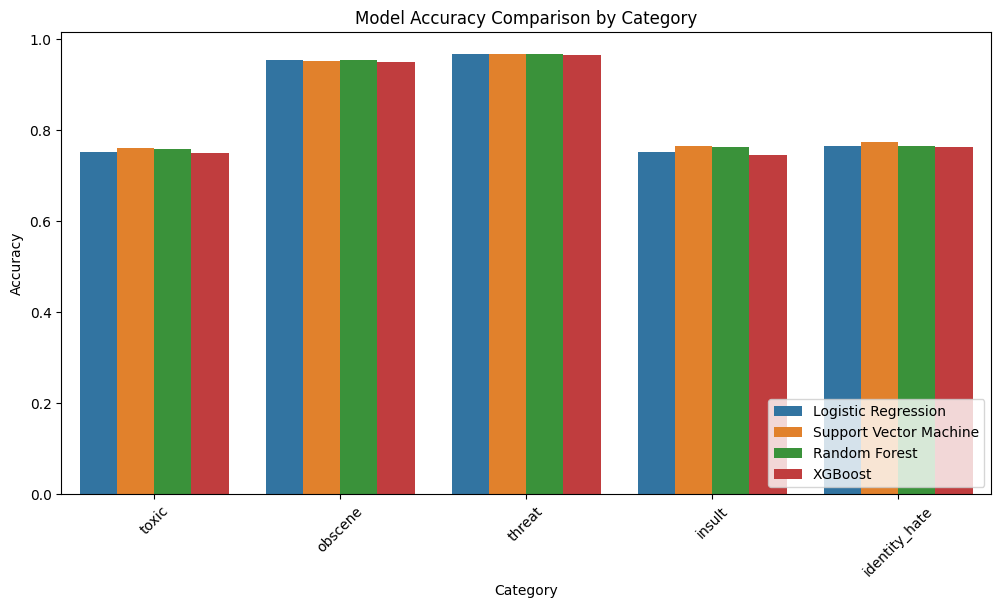

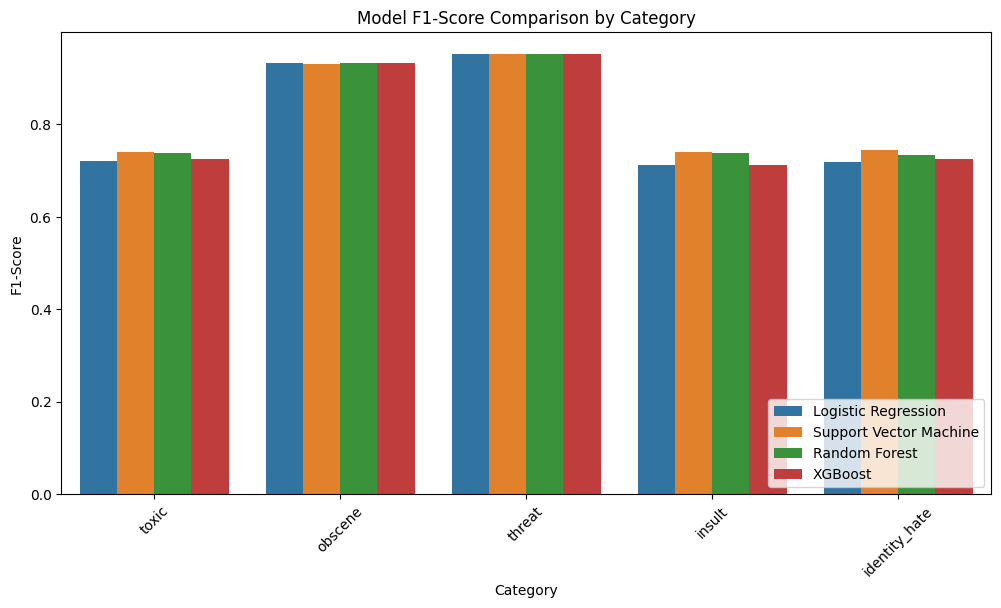

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Download NLTK resources
nltk.download('stopwords')

# Load the dataset
file_path = "olid-training-v1.0.xlsx"
df = pd.read_excel(file_path)

# Mapping OLID labels to toxicity categories
def map_toxicity(row):
    categories = {
        'toxic': 0, 'severe_toxic': 0, 'obscene': 0,
        'threat': 0, 'insult': 0, 'identity_hate': 0
    }

    if row['subtask_a'] == 'OFF':
        categories['toxic'] = 1  # General toxicity
        if row['subtask_b'] == 'TIN':
            categories['insult'] = 1  # Insults
            if row['subtask_c'] == 'IND' or row['subtask_c'] == 'GRP':
                categories['identity_hate'] = 1  # Identity-based hate
            if row['subtask_c'] == 'OTH':
                categories['threat'] = 1  # Other threats
        elif row['subtask_b'] == 'UNT':
            categories['obscene'] = 1  # Untargeted offensive speech
    return pd.Series(categories)

# Apply the mapping
df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = df.apply(map_toxicity, axis=1)

# Text cleaning function
def clean_text(text):
    # Convert to string to handle potential non-string values
    text = str(text)
    text = text.lower()
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(f"[{string.punctuation}]", '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))
    return text

# Apply text cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_tweet'])
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Store results
table_results = []

# Train and evaluate models for each toxicity category
for category in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f"Training models for {category}...")
    # Select target variable for the current category
    y_train_category = y_train[category]
    y_test_category = y_test[category]

    # Check if y_train_category contains more than one class
    if len(y_train_category.unique()) > 1:
        for name, model in models.items():
            print(f"Training {name}...")
            # Fit the model using the target variable for the current category
            model.fit(X_train, y_train_category)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test_category, y_pred)
            report = classification_report(y_test_category, y_pred, output_dict=True)
            f1_score = report['weighted avg']['f1-score']
            table_results.append([category, name, accuracy, f1_score])
            print(f"Performance of {name} for {category}:")
            print(classification_report(y_test_category, y_pred))
            print(f"Accuracy: {accuracy:.4f}")
            print("-" * 50)
    else:
        print(f"Skipping {category} due to insufficient class representation in training data.")

# Convert results to DataFrame and display as table
results_df = pd.DataFrame(table_results, columns=["Category", "Model", "Accuracy", "F1-Score"])
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Category", y="Accuracy", hue="Model", data=results_df)
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison by Category")
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Category", y="F1-Score", hue="Model", data=results_df)
plt.xticks(rotation=45)
plt.title("Model F1-Score Comparison by Category")
plt.legend(loc='lower right')
plt.show()
